# Notebook implementation


!pip install labelme tensorflow opencv-python matplotlib albumentations

In [10]:
import os
import time
import uuid
import cv2

In [38]:
os.getcwd()

'd:\\Deep Learning\\Face detection model\\notebook'

In [39]:
IMAGES_PATH = os.path.join('../data','images')
number_images = 30

In [40]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collectingh Images {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Collectingh Images 0
Collectingh Images 1
Collectingh Images 2
Collectingh Images 3
Collectingh Images 4
Collectingh Images 5
Collectingh Images 6
Collectingh Images 7
Collectingh Images 8
Collectingh Images 9
Collectingh Images 10
Collectingh Images 11
Collectingh Images 12
Collectingh Images 13
Collectingh Images 14
Collectingh Images 15
Collectingh Images 16
Collectingh Images 17
Collectingh Images 18
Collectingh Images 19
Collectingh Images 20
Collectingh Images 21
Collectingh Images 22
Collectingh Images 23
Collectingh Images 24
Collectingh Images 25
Collectingh Images 26
Collectingh Images 27
Collectingh Images 28
Collectingh Images 29


# Labeling images

In [41]:
!labelme

2024-12-08 16:00:48,785 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\radhe shayam\.labelmerc


# REVIEW DATASET

In [11]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [112]:
# images = tf.data.Dataset.list_files('..\\data\\images\\*.jpg', shuffle=False)
images = tf.data.Dataset.list_files('..\\data\\images\\*.jpg', shuffle=True)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ..\\data\\images\\*.jpg'

In [44]:
images.as_numpy_iterator().next()

b'..\\data\\images\\72eb65cc-b54f-11ef-87f2-30050593c1b3.jpg'

In [45]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [46]:
images = images.map(load_image)

In [47]:
images.as_numpy_iterator().next()

array([[[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [107, 103,  92],
        [104, 100,  91],
        [102,  98,  89]],

       [[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [108, 104,  93],
        [106, 102,  93],
        [105, 101,  92]],

       [[239, 239, 239],
        [239, 239, 239],
        [239, 239, 239],
        ...,
        [108, 106,  94],
        [107, 104,  95],
        [107, 104,  95]],

       ...,

       [[ 32,  31,  26],
        [ 32,  31,  26],
        [ 32,  31,  26],
        ...,
        [ 27,  25,  26],
        [ 27,  25,  26],
        [ 26,  24,  25]],

       [[ 32,  32,  24],
        [ 32,  32,  24],
        [ 31,  31,  23],
        ...,
        [ 28,  26,  27],
        [ 27,  25,  26],
        [ 28,  26,  27]],

       [[ 32,  32,  24],
        [ 31,  31,  23],
        [ 31,  31,  23],
        ...,
        [ 26,  24,  25],
        [ 27,  25,  26],
        [ 29,  27,  28]]

### View Imgages

In [188]:
image_generator = images.batch(4).as_numpy_iterator()

AttributeError: 'numpy.ndarray' object has no attribute 'batch'

In [49]:
plot_images = image_generator.next()

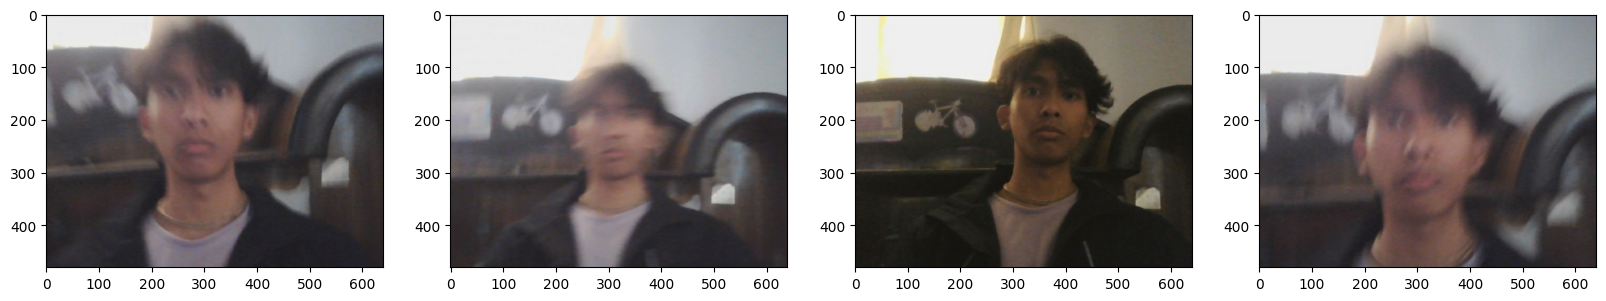

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### Partition Unaugmented Data

#### manually split data into train test and val

In [51]:
90*.7 # 63 to train

62.99999999999999

In [52]:
90*.15 # 14 and 13 for test and val

13.5

In [12]:
import shutil
import math

In [55]:
source_dir = '..\\data\\images\\'
train_dir = '..\\data\\train\\images\\'
test_dir = '..\\data\\test\\images\\'
val_dir = '..\\data\\val\\images\\'

# Ensure the target directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all image files
images = tf.io.gfile.glob(os.path.join(source_dir, '*.jpg'))

# Shuffle the images
images = tf.random.shuffle(images).numpy()

# Split the dataset
total_images = len(images)
train_size = math.ceil(total_images * 0.7)  # 70% for training
test_size = math.ceil(total_images * 0.15)  # 15% for testing
val_size = total_images - train_size - test_size  # Remaining for validation

train_images = images[:train_size]
test_images = images[train_size:train_size + test_size]
val_images = images[train_size + test_size:]

# Helper function to copy files
def copy_files(file_list, target_dir):
    for file_path in file_list:
        shutil.copy(file_path.decode('utf-8'), target_dir)  # Decode as tf returns byte strings

# Copy the files to respective folders
copy_files(train_images, train_dir)
copy_files(test_images, test_dir)
copy_files(val_images, val_dir)

print(f"{len(train_images)} images copied to Train.")
print(f"{len(test_images)} images copied to Test.")
print(f"{len(val_images)} images copied to Val.")

21 images copied to Train.
5 images copied to Test.
4 images copied to Val.


### move the matching labels

In [56]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('../data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('../data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('../data', folder, 'labels', filename)
            shutil.copy(existing_filepath, new_filepath)

### Empty the main images and labels folder

In [57]:
# Paths to the directories
directories = [
    '../data/images',
    '../data/labels'
]

# Iterate through each directory and remove its contents
for directory in directories:
    if os.path.exists(directory):
        for file in os.listdir(directory):
            file_path = os.path.join(directory, file)
            try:
                # Check if it's a file or directory and remove
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove the file or symbolic link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove the directory and its contents
            except Exception as e:
                print(f"Error removing {file_path}: {e}")

print("All specified folders have been emptied.")


All specified folders have been emptied.


### 4. Applying image augmentation on images and labels using Albumentations

In [113]:
import albumentations as alb

In [229]:
SIZE = 450

In [230]:
augmentor = alb.Compose([alb.RandomCrop(width=SIZE, height=SIZE),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations',
                                                    label_fields=['class_labels']))

d:\Deep Learning\Face detection model\.venv\Lib\site-packages\pydantic\main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...6, 0.0784313725490196)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [262]:
img = cv2.imread(os.path.join("../data", 'train','images',"a8cdede3-b52b-11ef-8c43-30050593c1b3.jpg"))

In [263]:
with open(os.path.join("..\\data", 'train','labels',"a8cdede3-b52b-11ef-8c43-30050593c1b3.json"),'r') as f:
    label = json.load(f)

In [264]:
label

{'version': '5.5.0',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[287.55319148936167, 62.3404255319149],
    [468.404255319149, 268.72340425531917]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {},
   'mask': None}],
 'imagePath': '..\\images\\a8cdede3-b52b-11ef-8c43-30050593c1b3.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnL

In [265]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [266]:
coords

[287.55319148936167, 62.3404255319149, 468.404255319149, 268.72340425531917]

In [267]:
img.shape

(480, 640, 3)

In [268]:
coords = list(np.divide(coords,[640,480,640,480]))

In [269]:
coords

[np.float64(0.4493018617021276),
 np.float64(0.1298758865248227),
 np.float64(0.7318816489361704),
 np.float64(0.5598404255319149)]

#### 4.4 Apply augmentations and view results

In [270]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [271]:
augmented['image'].shape

(450, 450, 3)

In [272]:
augmented['bboxes']

[[0.4412293243408203,
  0.43172575208875863,
  0.8431206088595921,
  0.8903546131981743]]

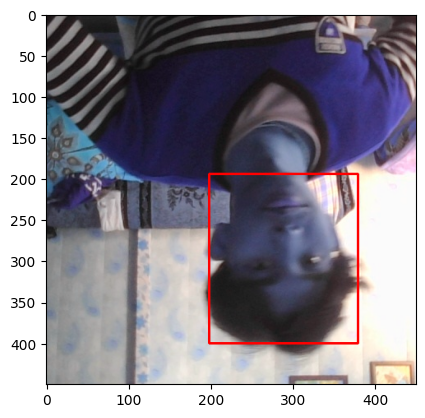

In [273]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented['image'])

### Building and running augmentation pipeline

In [274]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('../data', partition, 'images')):
        img = cv2.imread(os.path.join('../data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('../data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(10):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('../aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('../aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.66950333 0.82180059 0.30957031 0.19308035 0.        ].
x_max is less than or equal to x_min for bbox [0.76297432 0.69159228 0.257952   0.00520833 0.        ].
x_max is less than or equal to x_min for bbox [0.63881141 0.68043154 0.26353237 0.08333334 0.        ].
x_max is less than or equal to x_min for bbox [0.64997208 0.58556545 0.39188057 0.1875     0.        ].
x_max is less than or equal to x_min for bbox [0.64857703 0.5948661  0.37234932 0.1875     0.        ].
x_max is less than or equal to x_min for bbox [0.6374163  0.60416669 0.38769531 0.17075893 0.        ].
x_max is less than or equal to x_min for bbox [0.8717913  0.65625    0.59556359 0.18005952 0.        ].
x_max is less than or equal to x_min for bbox [0.39606586 0.66183037 0.12262835 0.22842261 0.        ].
y_max is less than or equal to y_min for bbox [0.61090958 0.61532736 0.96665734 0.03683036 0.        ].
x_max is less than or equal to x_min for bbox [0.56208146 0.5818

## Run from this block to run experiment

### Load augmented images to Tensorflow Dataset

In [14]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
train_images = tf.data.Dataset.list_files('..\\aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [16]:
test_images = tf.data.Dataset.list_files('..\\aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [17]:
val_images = tf.data.Dataset.list_files('..\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [18]:
train_images.as_numpy_iterator().next()

array([[[0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        ...,
        [0.49442402, 0.46795344, 0.41452205],
        [0.48921567, 0.4627451 , 0.40931374],
        [0.48713234, 0.4557598 , 0.4047794 ]],

       [[0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        ...,
        [0.49270833, 0.4623162 , 0.41084558],
        [0.49362746, 0.4632353 , 0.4117647 ],
        [0.47873774, 0.4526348 , 0.39840686]],

       [[0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        [0.9372549 , 0.9372549 , 0.9372549 ],
        ...,
        [0.4779412 , 0.46617648, 0.40735295],
        [0.48235294, 0.47058824, 0.40490195],
        [0.49123776, 0.469424  , 0.40539217]],

       ...,

       [[0.13363971, 0.11795343, 0.10618872],
        [0.13137256, 0.11715686, 0.10490196],
        [0.10245098, 0

### 6. Prepare Labels

##### 6.1 Label building function

In [19]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

##### 6.2 Load Label in Tensorflow dataset

In [20]:
train_labels = tf.data.Dataset.list_files('..\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [21]:
test_labels = tf.data.Dataset.list_files('..\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [22]:
val_labels = tf.data.Dataset.list_files('..\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [23]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.4507, 0.1081, 0.8496, 0.574 ], dtype=float16))

### Combine Image and Label samples

In [24]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(420, 420, 110, 110, 80, 80)

In [25]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(3000)
train = train.batch(8)
train = train.prefetch(4)

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(800)
test = test.batch(8)
test = test.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(500)
val = val.batch(8)
val = val.prefetch(4)

In [28]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.3372 , 0.1666 , 0.7456 , 0.655  ],
        [0.1558 , 0.     , 0.6914 , 0.4832 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1239 , 0.3674 , 0.5425 , 0.8237 ],
        [0.386  , 0.4573 , 0.7334 , 0.8936 ],
        [0.09863, 0.1266 , 0.5073 , 0.6147 ],
        [0.2153 , 0.4983 , 0.5703 , 0.939  ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

##### Viewing images and anotations

In [29]:
data_samples = train.as_numpy_iterator()

In [30]:
res = data_samples.next()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

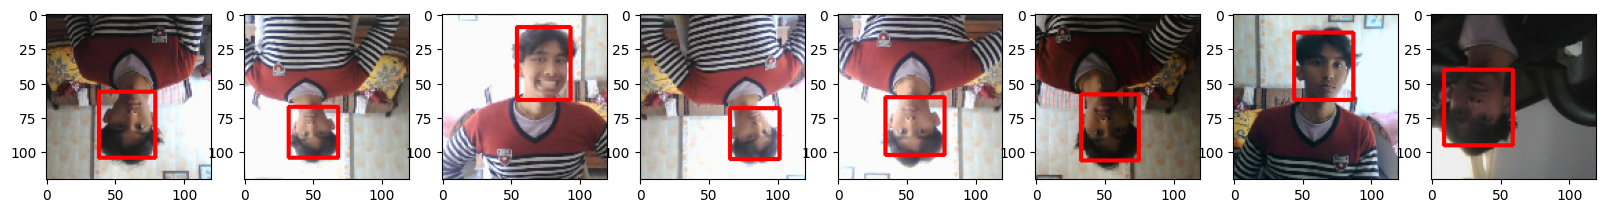

In [31]:
fig, ax = plt.subplots(ncols=8, figsize=(20, 20))
for idx in range(8): 
    sample_image = res[0][idx].copy()  # Make a writable copy of the image
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)
plt.show()


In [33]:
def delete_aug_data():
# Paths to the directories
    directories = [
        '../aug_data/test/images',
        '../aug_data/test/labels',
        '../aug_data/train/images',
        '../aug_data/train/labels',
        '../aug_data/val/images',
        '../aug_data/val/labels',
        
    ]
    
    # Iterate through each directory and remove its contents
    for directory in directories:
        if os.path.exists(directory):
            for file in os.listdir(directory):
                file_path = os.path.join(directory, file)
                try:
                    # Check if it's a file or directory and remove
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)  # Remove the file or symbolic link
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)  # Remove the directory and its contents
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")
    
    print("All specified folders have been emptied.")


### Deep learning mode training with functional APIs

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPool2D 
from tensorflow.keras.applications import VGG16

#### Downloaing VGG16

In [35]:
vgg = VGG16(include_top=False)

In [36]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPool2D()(vgg)
    class1 = Dense(1024, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPool2D()(vgg)
    regress1 = Dense(1024, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [64]:
facetracker = build_model()
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │    525,312 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │    525,312 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      1,025 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      4,100 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,770,437 (60.16 MB)

 Trainable params: 15,770,437 (60.16 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
X, y = train.as_numpy_iterator().next()

In [66]:
X.shape

(8, 120, 120, 3)

In [67]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step


In [68]:
classes, coords

(array([[0.3299387 ],
        [0.3873764 ],
        [0.53037924],
        [0.57866204],
        [0.5001997 ],
        [0.35128978],
        [0.4708003 ],
        [0.52906287]], dtype=float32),
 array([[0.46185672, 0.38079998, 0.6314306 , 0.77647716],
        [0.40065807, 0.3062226 , 0.72316   , 0.7349708 ],
        [0.45697767, 0.39833102, 0.50014925, 0.81366694],
        [0.54807705, 0.44945222, 0.54474   , 0.75918573],
        [0.48419666, 0.31218252, 0.7309648 , 0.7017062 ],
        [0.360847  , 0.32359675, 0.7132491 , 0.72727823],
        [0.339698  , 0.31851858, 0.63207126, 0.72953224],
        [0.52782714, 0.48768172, 0.62817067, 0.7801268 ]], dtype=float32))

### Defining losses and Optimizers

In [69]:
len(train)

53

In [70]:
batch_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batch_per_epoch

In [71]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

d:\Deep Learning\Face detection model\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


##### create localization loss and classificatino loss

In [72]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [73]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [74]:
coords

array([[0.46185672, 0.38079998, 0.6314306 , 0.77647716],
       [0.40065807, 0.3062226 , 0.72316   , 0.7349708 ],
       [0.45697767, 0.39833102, 0.50014925, 0.81366694],
       [0.54807705, 0.44945222, 0.54474   , 0.75918573],
       [0.48419666, 0.31218252, 0.7309648 , 0.7017062 ],
       [0.360847  , 0.32359675, 0.7132491 , 0.72727823],
       [0.339698  , 0.31851858, 0.63207126, 0.72953224],
       [0.52782714, 0.48768172, 0.62817067, 0.7801268 ]], dtype=float32)

In [75]:
y[1]

array([[0.455  , 0.4353 , 0.854  , 0.87   ],
       [0.048  , 0.09186, 0.45   , 0.5503 ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ],
       [0.325  , 0.10095, 0.6743 , 0.5137 ],
       [0.1774 , 0.08484, 0.5107 , 0.545  ],
       [0.4285 , 0.4712 , 0.774  , 0.87   ],
       [0.     , 0.3884 , 0.3416 , 0.8804 ]], dtype=float16)

In [76]:
localization_loss(y[1], coords).numpy()

np.float32(1.9706731)

In [77]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8507771492004395>

In [78]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.9706730842590332>

### Training Neural Network

In [79]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch

        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)

            # Ensure static shapes for classification loss
            y_class = tf.reshape(y[0], [-1])  # Shape (batch_size,)
            classes_reshaped = tf.reshape(classes, [-1])  # Shape (batch_size,)

            batch_classloss = self.closs(y_class, classes_reshaped)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

        grad = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(
            tf.reshape(y[0], [-1]),  # Ensures shape (batch_size,)
            tf.reshape(classes, [-1])  # Ensures shape (batch_size,)
            )
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [80]:
model = FaceTracker(facetracker)


In [81]:
model.compile(opt, classloss, regressloss)


In [82]:
logdir = '../logs'

In [83]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Dagshub and mlfow implementation

In [84]:
import mlflow
from dagshub import DAGsHubLogger

# Set the DagsHub repository details
DAGSHUB_USERNAME = "dhruvghimiray"
mlflow.set_tracking_uri("https://dagshub.com/dhruvghimiray/Face-detection-model.mlflow")

import dagshub
dagshub.init(repo_owner='dhruvghimiray', repo_name='Face-detection-model', mlflow=True)


Initialized MLflow to track repo "dhruvghimiray/Face-detection-model"

Repository dhruvghimiray/Face-detection-model initialized!

In [86]:
epochs=10

In [88]:
import uuid
import datetime

In [89]:
# Define the folder to save models
models_folder = "../models"
os.makedirs(models_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Generate a unique name for the model
experiment_name = "facetracker_model"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
unique_name = f"{experiment_name}_{timestamp}_{str(uuid.uuid4())[:8]}.h5"
model_path = os.path.join(models_folder, unique_name)

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss_weight", 0.5)

    # Train the model
    hist = model.fit(train, epochs=epochs, validation_data=val, callbacks=[tensorboard_callback])

    # Log metrics for each epoch
    for epoch in range(4):
        mlflow.log_metric("train_total_loss", hist.history['total_loss'][epoch], step=epoch)
        mlflow.log_metric("val_total_loss", hist.history['val_total_loss'][epoch], step=epoch)
        mlflow.log_metric("train_class_loss", hist.history['class_loss'][epoch], step=epoch)
        mlflow.log_metric("val_class_loss", hist.history['val_class_loss'][epoch], step=epoch)
        mlflow.log_metric("train_regress_loss", hist.history['regress_loss'][epoch], step=epoch)
        mlflow.log_metric("val_regress_loss", hist.history['val_regress_loss'][epoch], step=epoch)

    # Save the model locally in ../models folder
    model.save(model_path)
    print(f"Model saved locally as {model_path}")

    # Log the model file as an artifact in MLflow
    mlflow.log_artifact(model_path)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 874ms/step - class_loss: 2.9266e-04 - regress_loss: 0.0131 - total_loss: 0.0133 - val_class_loss: 7.7617e-04 - val_regress_loss: 0.0543 - val_total_loss: 0.0547
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 868ms/step - class_loss: 2.4697e-04 - regress_loss: 0.0120 - total_loss: 0.0121 - val_class_loss: 3.2705e-04 - val_regress_loss: 0.0404 - val_total_loss: 0.0405
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 858ms/step - class_loss: 2.7155e-04 - regress_loss: 0.0132 - total_loss: 0.0133 - val_class_loss: 1.2507e-04 - val_regress_loss: 0.0520 - val_total_loss: 0.0521
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 881ms/step - class_loss: 2.8405e-04 - regress_loss: 0.0139 - total_loss: 0.0140 - val_class_loss: 6.1940e-04 - val_regress_loss: 0.0608 - val_total_loss: 0.0611
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 921ms/step - class_loss: 2.0523e-04 - regress_loss: 0.0093 - total_loss: 0.0094 - val_class_loss: 0.0021 - val_regress_loss: 0.0337 - val_total_lo

Model saved locally as ../models\facetracker_model_20241209_130012_d2efccf9.h5
🏃 View run upbeat-carp-883 at: https://dagshub.com/dhruvghimiray/Face-detection-model.mlflow/#/experiments/1/runs/9ac6a04a4b8047e48ee46caaaab31bc8
🧪 View experiment at: https://dagshub.com/dhruvghimiray/Face-detection-model.mlflow/#/experiments/1


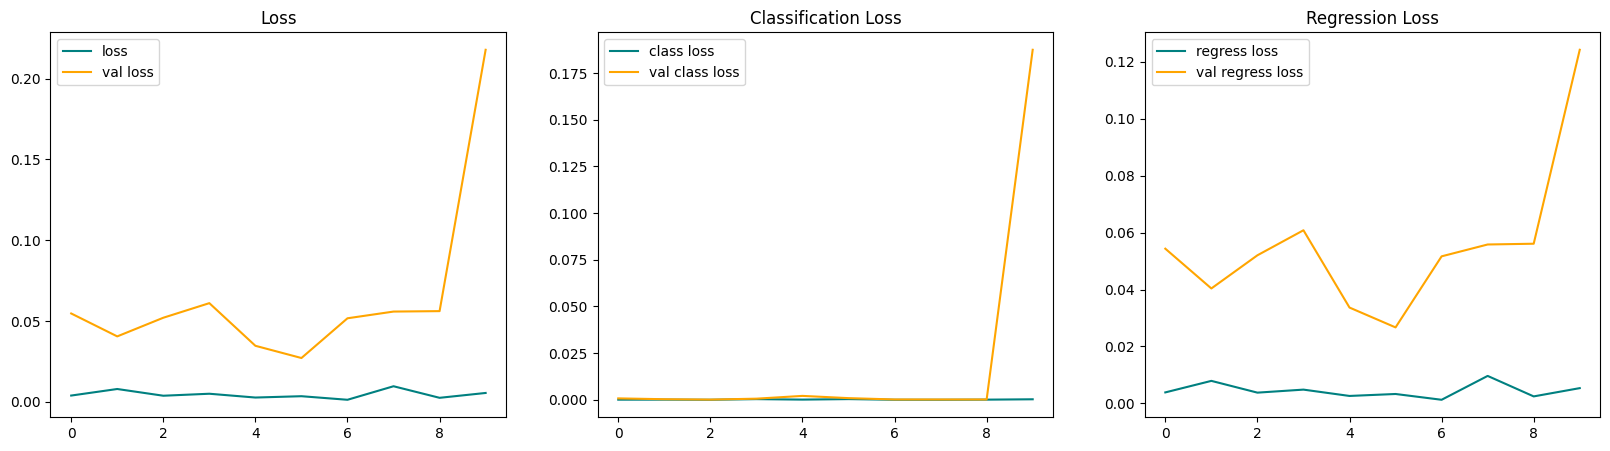

In [90]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Making predictions

In [91]:
test_data = test.as_numpy_iterator()


In [92]:
test_sample = test_data.next()


In [93]:
yhat = facetracker.predict(test_sample[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


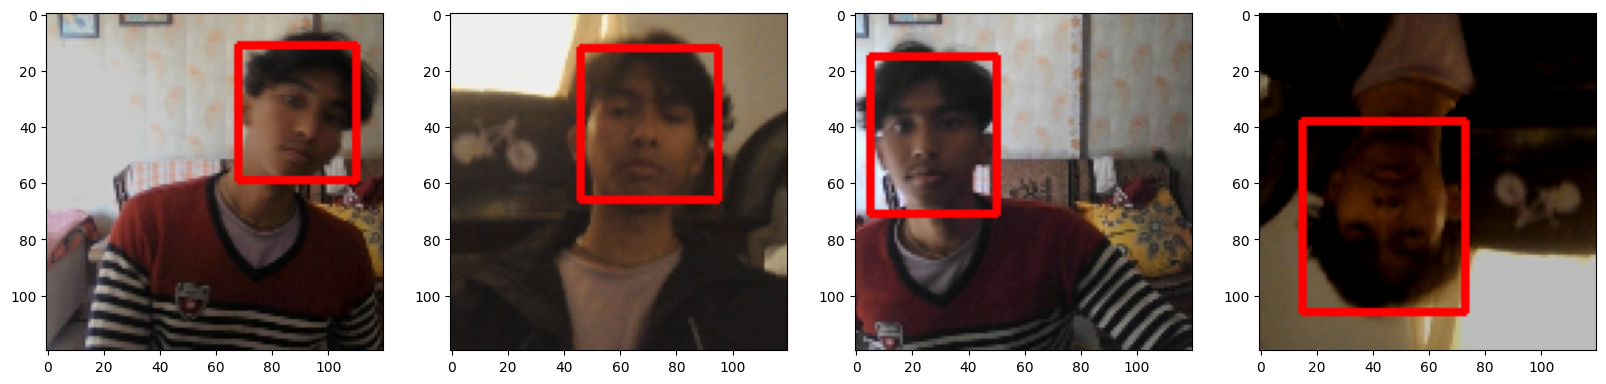

In [94]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Create a writable copy
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

##### Saving the models

In [95]:
from tensorflow.keras.models import load_model


In [98]:
facetracker.save('../models/facetracker.h5')


##### Real Time Detection

In [97]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━